# Evaluation of Lorenz GAN Models

The goal of this notebook is to evaluate the quality of the representation of the Lorenz 96 GAN parameterization.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import keras.backend as K
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from keras.models import load_model
from lorenz_gan.gan import Interpolate1D
import pandas as pd
from scipy.stats import expon, lognorm
import pickle

Using TensorFlow backend.


In [2]:
def normalize_data(data, scaling_values=None):
    """
    Normalize each channel in the 4 dimensional data matrix independently.

    Args:
        data: 4-dimensional array with dimensions (example, y, x, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
    for i in range(data.shape[-1]):
        scaling_values.loc[i, ["mean", "std"]] = [data[:, :, i].mean(), data[:, :, i].std()]
        normed_data[:, :, i] = (data[:, :, i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values


def unnormalize_data(normed_data, scaling_values):
    """
    Re-scale normalized data back to original values

    Args:
        normed_data: normalized data
        scaling_values: pandas dataframe of mean and standard deviation from normalize_data

    Returns:
        Re-scaled data
    """
    data = np.zeros(normed_data.shape, dtype=normed_data.dtype)
    for i in range(normed_data.shape[-1]):
        data[:, :, i] = normed_data[:, :, i] * scaling_values.loc[i, "std"] + scaling_values.loc[i, "mean"]
    return data

def fit_condition_distributions(train_cond_data):
    """
    Calculate the scale parameter for the exponential distribution of correlated conditional variables
    for the Lorenz 96 model in time.

    Args:
        train_cond_data: array of conditioning values where the first column is the current X, and each
            other column is a lagged X value

    Returns:
        array of scale values
    """
    train_cond_exp_scale = np.zeros(train_cond_data.shape[1] - 1)
    for i in range(1, train_cond_data.shape[1]):
        train_cond_exp_scale[i - 1] = expon.fit(np.abs(train_cond_data[:, 0] - train_cond_data[:, i]), floc=0)[1]
    return train_cond_exp_scale


def generate_random_condition_data(batch_size, num_cond_inputs, train_cond_scale):
    """
    Generate correlated conditional random numbers to train the generator network.

    Args:
        batch_size: number of random samples
        num_cond_inputs: number of conditional inputs
        train_cond_scale: exponential distribution scale values

    Returns:

    """
    batch_cond_data = np.zeros((batch_size, num_cond_inputs, 1))
    batch_cond_data[:, 0, 0] = np.random.normal(size=batch_size)
    for t in range(1, train_cond_scale.size + 1):
        batch_cond_data[:, t , 0] = batch_cond_data[:, 0, 0] + \
                                    np.random.choice([-1, 1], size=batch_size) * expon.rvs(loc=0,
                                                                                           scale=train_cond_scale[t-1],
                                                                                           size=batch_size)
    return batch_cond_data

Load generator model

In [321]:
gen_model = load_model("../exp/gan_generator_0000_epoch_0010.h5", custom_objects={"Interpolate1D": Interpolate1D})

In [229]:
print(gen_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 256)           512         input_2[0][0]                    
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 4, 64)         0           dense_1[0][0]                    
___________________________________________________________________________________________

(1, 32, 1)


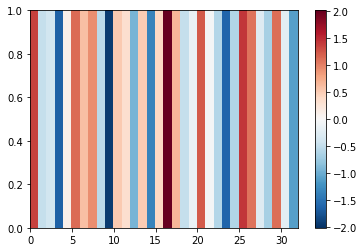

In [322]:
layer_func = K.function(gen_model.input + [K.learning_phase()], [gen_model.layers[19].output])
out = layer_func([np.array([[3]]), np.array([[-2]]), True])[0]
print(out.shape)
#plt.plot(out[0].T)
m_val = np.max(np.abs(out[0].T))
plt.pcolormesh(out[0].T, vmin=-m_val, vmax=m_val, cmap="RdBu_r")
plt.colorbar()

In [324]:
gan_samples = xr.open_dataset("../exp/gan_gen_patches_0000_epoch_0010.nc")
patches = gan_samples["gen_samples"][:, :, 0].values
gan_samples.close()

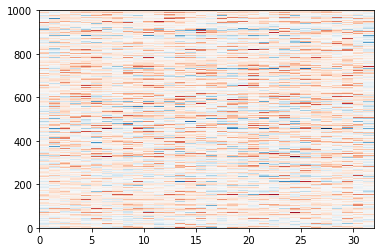

In [325]:
plt.pcolormesh(patches, vmin=-2, vmax=2, cmap="RdBu_r")

(array([  12.,   21.,   51.,  494.,  299.,   68.,   32.,   16.,    5.,    2.]),
 array([-0.13206375, -0.07275748, -0.01345121,  0.04585506,  0.10516133,
         0.1644676 ,  0.22377387,  0.28308014,  0.34238641,  0.40169268,
         0.46099895]),
 <a list of 10 Patch objects>)

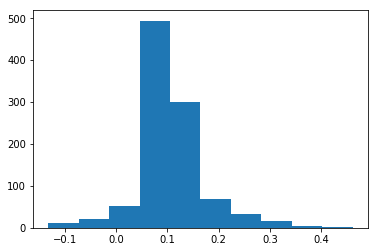

In [227]:
plt.hist(patches[:, 0])

(array([  25.,   68.,   90.,   90.,  112.,  183.,  182.,  150.,   79.,   21.]),
 array([-11.89845657,  -8.94517956,  -5.99190254,  -3.03862553,
         -0.08534851,   2.8679285 ,   5.82120552,   8.77448254,
         11.72775955,  14.68103657,  17.63431358]),
 <a list of 10 Patch objects>)

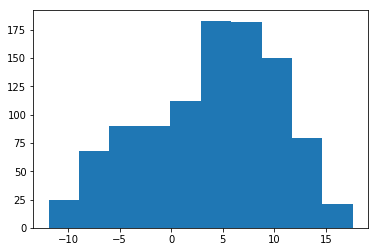

In [232]:
plt.hist(patches.sum(axis=1))

In [326]:
gan_loss = pd.read_csv("../exp/gan_loss_history_0000.csv", index_col="Time")
gan_loss["Epoch_Batch"] = gan_loss["Epoch"].values * gan_loss["Batch"].max() + gan_loss["Batch"].values
gan_loss["Epoch_Batch"] = gan_loss["Epoch_Batch"] / gan_loss["Epoch_Batch"].max() * gan_loss["Epoch"].max()

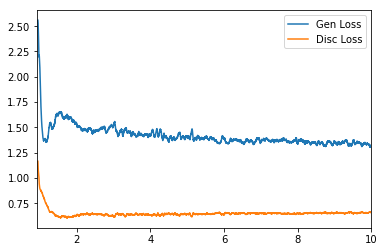

In [327]:

gan_loss[["Gen Loss", "Disc Loss"]].rolling(100).mean().plot(x=gan_loss["Epoch_Batch"].values)


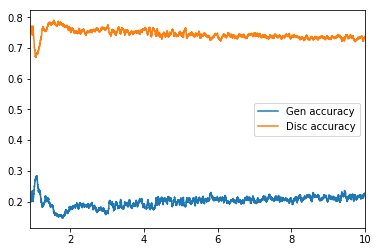

In [328]:
gan_loss[["Gen accuracy", "Disc accuracy"]].rolling(100).mean().plot(x=gan_loss["Epoch_Batch"].values)

In [113]:
combined_data = pd.read_csv("../exp/lorenz_combined_output.csv")
y_cols = combined_data.columns[combined_data.columns.str.contains("Y")]
x_cols = combined_data.columns[combined_data.columns.str.contains("X")]
x_cols = ["X_t"]
print(y_cols)
print(x_cols)

Index(['Y_0', 'Y_1', 'Y_2', 'Y_3', 'Y_4', 'Y_5', 'Y_6', 'Y_7', 'Y_8', 'Y_9',
       'Y_10', 'Y_11', 'Y_12', 'Y_13', 'Y_14', 'Y_15', 'Y_16', 'Y_17', 'Y_18',
       'Y_19', 'Y_20', 'Y_21', 'Y_22', 'Y_23', 'Y_24', 'Y_25', 'Y_26', 'Y_27',
       'Y_28', 'Y_29', 'Y_30', 'Y_31'],
      dtype='object')
['X_t']


In [205]:
x_norm, x_scaling = normalize_data(np.expand_dims(combined_data[x_cols].values, axis=-1))
y_norm, y_scaling = normalize_data(np.expand_dims(combined_data[y_cols].values, axis=-1))


In [308]:
gan_norm.std(axis=0)

array([[ 0.99669999],
       [ 0.99875307],
       [ 0.76436281],
       [ 0.86128545],
       [ 0.84555477],
       [ 1.14781666],
       [ 0.91927868],
       [ 1.04809284],
       [ 0.96286786],
       [ 1.00868678],
       [ 0.9743709 ],
       [ 0.91122478],
       [ 0.94979173],
       [ 0.87552577],
       [ 0.90673542],
       [ 0.8771441 ],
       [ 1.05454648],
       [ 0.88939691],
       [ 0.9356246 ],
       [ 0.90181011],
       [ 0.92331135],
       [ 1.02853405],
       [ 0.77518845],
       [ 0.88265449],
       [ 0.82356375],
       [ 1.1389513 ],
       [ 0.89471388],
       [ 1.08145523],
       [ 0.89192146],
       [ 1.07936358],
       [ 0.96457177],
       [ 1.00237703]], dtype=float32)

In [329]:
pred_func = K.function(gen_model.input + [K.learning_phase()], [gen_model.output])
gan_norm = pred_func([x_norm[:,:,0] , np.random.normal(size=(x_norm.shape[0], 1)), True])[0]
gan_y = unnormalize_data(gan_norm, y_scaling)

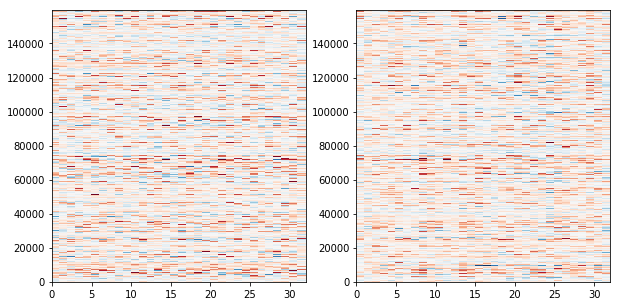

In [330]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pcolormesh(combined_data[y_cols], vmin=-2, vmax=2, cmap="RdBu_r")
axes[1].pcolormesh(gan_y[:, :, 0], vmin=-2, vmax=2, cmap="RdBu_r")

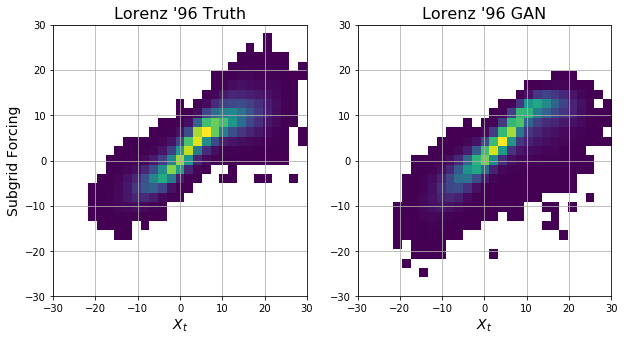

In [331]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].hist2d(combined_data["X_t"], combined_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                                   np.linspace(-30, 30, 30)], cmin=1)
#axes[0].plot(np.linspace(-30, 30, 10), np.linspace(-30, 30, 10), 'k--')
axes[0].set_title("Lorenz '96 Truth", fontsize=16)
_ = axes[1].hist2d(combined_data["X_t"], gan_y[:, :, 0].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                    np.linspace(-30, 30, 30)], cmin=1)
axes[1].set_title("Lorenz '96 GAN", fontsize=16)
axes[0].set_xlabel("$X_t$", fontsize=14)
axes[1].set_xlabel("$X_t$", fontsize=14)
axes[0].grid()
axes[1].grid()
axes[0].set_ylabel("Subgrid Forcing", fontsize=14)
plt.savefig("../exp/gan_x_ymean_hist.png", dpi=200, bbox_inches="tight")

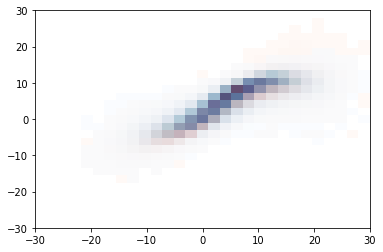

In [317]:
_ = plt.hist2d(combined_data["X_t"], combined_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
               np.linspace(-30, 30, 30)], cmin=1, cmap="Reds", alpha=0.6)

_ = plt.hist2d(combined_data["X_t"], gan_y[:, :, 0].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
               np.linspace(-30, 30, 30)], cmap="Blues", cmin=1, alpha=0.6)

In [72]:
y_data = combined_data[y_cols].values

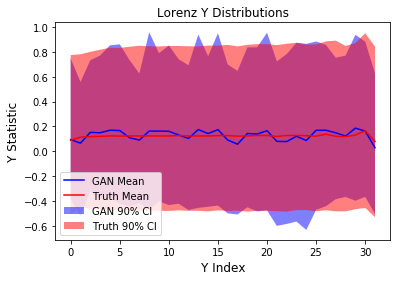

In [332]:
plt.fill_between(np.arange(32), np.percentile(gan_y[:, :, 0], 95, axis=0), 
                 np.percentile(gan_y[:, :, 0], 5, axis=0), alpha=0.5, label="GAN 90% CI", facecolor="blue")
plt.plot(gan_y[:, :, 0].mean(axis=0), label="GAN Mean", color="blue")
plt.fill_between(np.arange(32), np.percentile(y_data, 95, axis=0), 
                 np.percentile(y_data, 5, axis=0), alpha=0.5, facecolor="red", label="Truth 90% CI")
plt.plot(y_data.mean(axis=0), label="Truth Mean", color="red")
plt.legend(loc=3, fontsize=10)
plt.xlabel("Y Index", fontsize=12)
plt.ylabel("Y Statistic", fontsize=12)
plt.title("Lorenz Y Distributions")
plt.savefig("../exp/lorenz_y_dist.png", dpi=200, bbox_inches="tight")

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask = (resdat <= 0)
/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


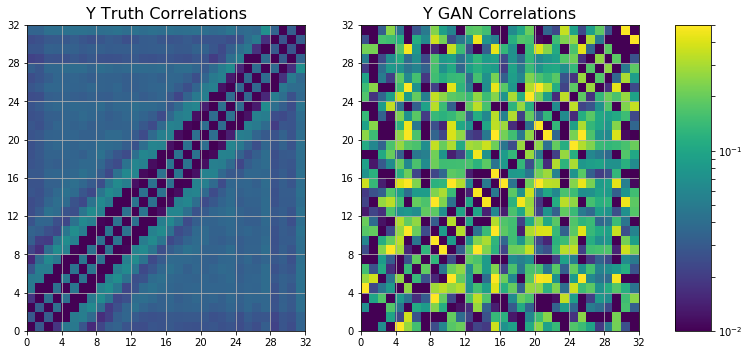

In [334]:
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(0.05, 0.05, 0.9, 0.9)
cax = fig.add_axes([0.95, 0.05, 0.05, .85])
truth_corr = np.corrcoef(y_data.T) **2
truth_corr[np.diag_indices(truth_corr.shape[0])] = np.nan
gan_corr = np.corrcoef(gan_y[:, :, 0].T)**2
gan_corr[np.diag_indices(truth_corr.shape[0])] = np.nan
pc = axes[0].pcolormesh(truth_corr, vmin=0.01, vmax=0.5, norm=LogNorm(0.01, 1))
axes[1].pcolormesh(gan_corr, vmin=0.01, vmax=0.2, norm=LogNorm(0.01, 1))
axes[0].set_title("Y Truth Correlations", fontsize=16)
axes[0].set_xticks(np.linspace(0, 32, 9))
axes[1].set_xticks(np.linspace(0, 32, 9))
axes[0].set_yticks(np.linspace(0, 32, 9))
axes[1].set_yticks(np.linspace(0, 32, 9))
axes[0].grid()
axes[1].grid()
axes[1].set_title("Y GAN Correlations", fontsize=16)
plt.colorbar(pc, cax=cax)
plt.savefig("../exp/y_gan_correlations.png", dpi=200, bbox_inches="tight")

(array([ 0.00792439,  0.01329252,  0.01623221,  0.02096128,  0.0282466 ,
         0.03808818,  0.04895226,  0.06505665,  0.0876795 ,  0.11758766,
         0.15887116,  0.20961279,  0.29128509,  0.38113741,  0.51789697,
         0.67574563,  0.8479093 ,  1.12219531,  1.33436436,  1.53221838,
         1.64277635,  1.62833351,  1.51317429,  1.3116137 ,  1.07439337,
         0.86810371,  0.72137475,  0.60378709,  0.51623541,  0.45015625,
         0.3871446 ,  0.33614734,  0.28975134,  0.23044626,  0.19772621,
         0.18123838,  0.1431502 ,  0.12078298,  0.10161108,  0.09291982,
         0.07387573]),
 array([ -1.00000000e+00,  -9.50000000e-01,  -9.00000000e-01,
         -8.50000000e-01,  -8.00000000e-01,  -7.50000000e-01,
         -7.00000000e-01,  -6.50000000e-01,  -6.00000000e-01,
         -5.50000000e-01,  -5.00000000e-01,  -4.50000000e-01,
         -4.00000000e-01,  -3.50000000e-01,  -3.00000000e-01,
         -2.50000000e-01,  -2.00000000e-01,  -1.50000000e-01,
         -1.00000000e

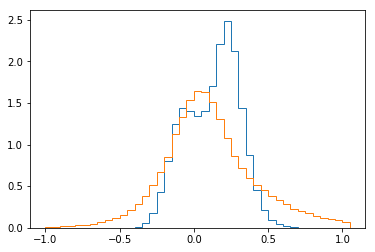

In [336]:
plt.hist(combined_data[y_cols].mean(axis=1), bins=np.arange(-1, 1.1, 0.05), normed=True, histtype="step")
plt.hist(gan_y[:, 28, 0], bins=np.arange(-1, 1.1, 0.05), normed=True, histtype="step")

(array([ 2.71322649,  2.43575573,  2.25568757,  2.10417242,  1.82301741,
         1.56488901,  1.28258267,  1.03021092,  0.87777471,  0.69954868,
         0.58165239,  0.48770379,  0.40342636,  0.35115594,  0.3030303 ,
         0.25513494,  0.20677904,  0.18513401,  0.1579626 ,  0.15243622,
         0.1287188 ]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ,  1.05]),
 <a list of 1 Patch objects>)

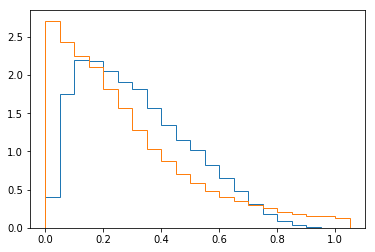

In [337]:
plt.hist(combined_data[y_cols].std(axis=1), bins=np.arange(0, 1.1, 0.05), normed=True, histtype="step")
plt.hist(gan_y[:, 0, 0], bins=np.arange(0, 1.1, 0.05), normed=True, histtype="step")

(array([  4.47340000e+04,   3.57560000e+04,   2.38510000e+04,
          1.61240000e+04,   1.12090000e+04,   7.91100000e+03,
          5.54900000e+03,   4.12200000e+03,   3.02400000e+03,
          2.13800000e+03,   1.58800000e+03,   1.17700000e+03,
          8.44000000e+02,   5.02000000e+02,   3.53000000e+02,
          2.57000000e+02,   1.80000000e+02,   1.41000000e+02,
          8.90000000e+01,   4.90000000e+01,   3.60000000e+01,
          1.80000000e+01,   1.10000000e+01,   1.30000000e+01,
          2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]),
 array([  3.81469727e-06,   2.06101688e-01,   4.12199561e-01,
          6.18297434e-01,   8.24395307e-01,   1.03049318e+00,
          1.23659105e+00,   1.44268893e+00,   1.64878680e+00,
          1.85488467e+00,   2.06098255e+00,   2.26708042e+00,
          2.47317829e+00,   2.67927616e+00,   2.88537404e+00,
          3.09147191e+00,   3.29756978e+00,   3.50366766e+00,
      

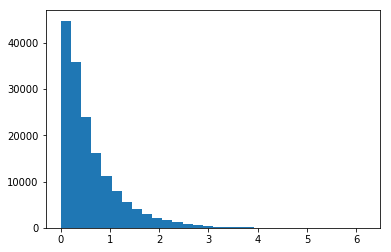

In [145]:
plt.hist(np.abs(combined_data["X_t-2"] - combined_data["X_t"]), bins=30)

In [154]:
exp_loc, exp_scale = expon.fit(np.abs(combined_data["X_t-1"] - combined_data["X_t"]), floc=0)
print(exp_loc, exp_scale)

0 0.298596191406


In [45]:
lorenz_series = xr.open_dataset("../exp/lorenz_output.nc")

In [61]:
x_values = lorenz_series["lorenz_x"][:, 0].to_dataframe()

In [91]:
lags = np.arange(5, 2001, 5)
auto_corr = np.zeros(lags.size)
for l, lag in enumerate(lags):
    auto_corr[l] = x_values["lorenz_x"].autocorr(lag)

In [94]:
auto_corr[:5]

array([ 0.99849999,  0.99401533,  0.98659175,  0.97630433,  0.96325586])

In [114]:
x_values["lorenz_x"].values[1000::5]

array([ 7.35938501,  7.64667892,  7.96005154, ...,  2.92966819,
        3.04421759,  3.16192937])

(array([  3.30000000e+01,   2.04000000e+02,   1.23100000e+03,
          4.92500000e+03,   1.70230000e+04,   6.69190000e+04,
          7.71400000e+04,   1.08750000e+04,   1.51200000e+03,
          1.21000000e+02]),
 array([-8.38181484, -6.95794361, -5.53407238, -4.11020114, -2.68632991,
        -1.26245868,  0.16141255,  1.58528378,  3.00915501,  4.43302624,
         5.85689747]),
 <a list of 10 Patch objects>)

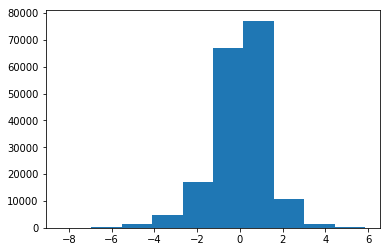

In [107]:
plt.hist(x_values["lorenz_x"].values[100:900015:5] - x_values["lorenz_x"].values[85:900000:5])

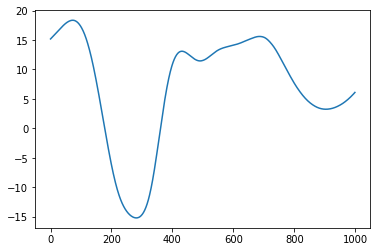

In [80]:
plt.plot(np.arange(1000), x_values.iloc[2000:3000, 1])

In [72]:
x_values.shape

(998001, 2)

(array([   126.,    180.,    565.,   1918.,   3632.,   7844.,  13770.,
         20660.,  29019.,  38926.,  47854.,  56198.,  64737.,  70152.,
         74519.,  79949.,  80543.,  74487.,  68967.,  57388.,  53141.,
         44603.,  37308.,  26730.,  19603.,  12166.,   8157.,   3743.,
           928.,    188.]),
 array([-3.3311972 , -3.12129442, -2.91139164, -2.70148886, -2.49158608,
        -2.2816833 , -2.07178052, -1.86187774, -1.65197496, -1.44207218,
        -1.2321694 , -1.02226662, -0.81236384, -0.60246106, -0.39255828,
        -0.1826555 ,  0.02724728,  0.23715006,  0.44705284,  0.65695562,
         0.8668584 ,  1.07676118,  1.28666396,  1.49656674,  1.70646952,
         1.9163723 ,  2.12627508,  2.33617786,  2.54608064,  2.75598342,
         2.9658862 ]),
 <a list of 30 Patch objects>)

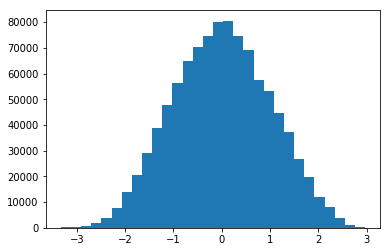

In [84]:
plt.hist((x_values["lorenz_x"] - x_values["lorenz_x"].mean()) / x_values['lorenz_x'].std(), 30)

In [115]:
all_x = lorenz_series["lorenz_x"].values

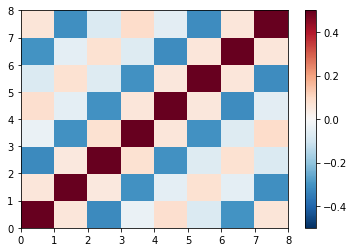

In [122]:
plt.pcolor(np.corrcoef(all_x.T), vmin=-0.5, vmax=0.5, cmap="RdBu_r")
plt.colorbar()

In [187]:
def fit_condition_distributions(train_cond_data):
    """
    Calculate the scale parameter for the exponential distribution of correlated conditional variables
    for the Lorenz 96 model in time.

    Args:
        train_cond_data: array of conditioning values where the first column is the current X, and each
            other column is a lagged X value

    Returns:
        array of scale values
    """
    train_cond_exp_scale = np.zeros(train_cond_data.shape[1] - 1)
    for i in range(1, train_cond_data.shape[1]):
        train_cond_exp_scale[i - 1] = expon.fit(np.abs(train_cond_data[:, 0] - train_cond_data[:, i]), floc=0)[1]
    return train_cond_exp_scale


def generate_random_condition_data(batch_size, num_cond_inputs, train_cond_scale):
    batch_cond_data = np.zeros((batch_size, num_cond_inputs, 1))
    batch_cond_data[:, 0, 0] = np.random.normal(size=batch_size)
    for t in range(1, train_cond_scale.size + 1):
        batch_cond_data[:, t , 0] = batch_cond_data[:, 0, 0] + \
                                    np.random.choice([-1, 1], size=batch_size) * expon.rvs(loc=0,
                                                                                           scale=train_cond_scale[t-1],
                                                                                           size=batch_size)
    return batch_cond_data

In [185]:
normed_x = (combined_data[x_cols] - combined_data[x_cols].mean()) / combined_data[x_cols].std()
normed_x = normed_x.values
print(normed_x.shape)

(159680, 3)


In [188]:
exp_scale = fit_condition_distributions(normed_x)
print(exp_scale)
batch_cond_data = generate_random_condition_data(128, 3, exp_scale)

[ 0.03906403  0.0780426 ]


In [86]:
rf = RandomForestRegressor(n_estimators=100, max_features="auto", max_depth=10)
rf.fit(combined_data[x_cols], combined_data[y_cols].mean(axis=1))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [87]:
out = rf.predict(combined_data[x_cols])

In [120]:
tree_preds = np.array([t.predict(combined_data[x_cols]) for t in rf.estimators_]).T

X_t      4.605129
X_t-1    4.347568
X_t-2    4.090302
Name: 0, dtype: float64


(array([  1.,   4.,   4.,  13.,  11.,  10.,   8.,   4.,  14.,  31.]),
 array([ 0.11398964,  0.12116318,  0.12833671,  0.13551025,  0.14268378,
         0.14985731,  0.15703085,  0.16420438,  0.17137792,  0.17855145,
         0.18572499]),
 <a list of 10 Patch objects>)

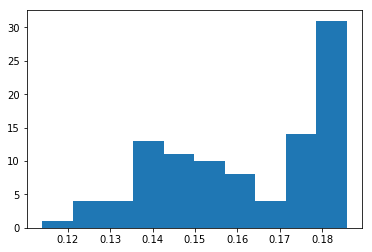

In [126]:
print(combined_data.loc[0, x_cols])
plt.hist(tree_preds[0])

(array([   2.,   11.,   53.,  114.,  227.,  261.,  196.,   97.,   30.,    9.]),
 array([ 0.15490953,  0.15617225,  0.15743498,  0.1586977 ,  0.15996042,
         0.16122315,  0.16248587,  0.1637486 ,  0.16501132,  0.16627404,
         0.16753677]),
 <a list of 10 Patch objects>)

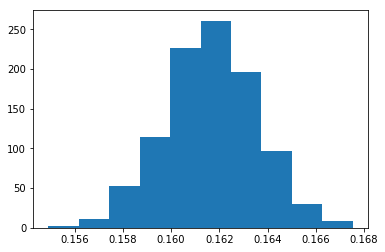

In [127]:
resampled_mean_preds = np.zeros(1000)
for i in range(1000):
    resampled_mean_preds[i] = np.random.choice(tree_preds[0], size=100, replace=True).mean()
plt.hist(resampled_mean_preds)

In [116]:
lm.coef_

array([ 0.00150673])

In [344]:
lorenz_data = xr.open_dataset("../exp/lorenz_output.nc")
x_vals = lorenz_data["lorenz_x"].values
lorenz_data.close()

In [345]:
lorenz_forecasts = []
lorenz_forecast_cube = np.zeros((10, 1001, 8))
for i in range(10):
    lorenz_forecasts.append(pd.read_csv("../exp/lorenz_forecast_{0:02d}.csv".format(i)))
    lorenz_forecast_cube[i] = lorenz_forecasts[i].iloc[:, 2:]

In [168]:
lorenz_forecasts[0]

,time,step,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7
0,0.000,0,2.721556,5.863500,19.907455,-3.038096,-0.902089,10.946190,10.587127,7.072505
1,0.005,1,2.683019,6.142241,19.698910,-3.520731,-0.596298,10.960845,11.069237,6.719968
2,0.010,2,2.651516,6.413687,19.480010,-3.996165,-0.281512,10.992012,11.515299,6.348198
3,0.015,3,2.622332,6.674190,19.264207,-4.454826,0.053704,11.043338,11.900537,5.959973
4,0.020,4,2.605424,6.939627,18.990874,-4.902086,0.384383,11.121337,12.269380,5.564638
5,0.025,5,2.585794,7.213671,18.715621,-5.327105,0.724729,11.231194,12.576598,5.139642
6,0.030,6,2.576326,7.473633,18.429627,-5.725660,1.067524,11.366020,12.835666,4.696054
7,0.035,7,2.589535,7.728183,18.118490,-6.099463,1.413798,11.531043,13.067463,4.235989
8,0.040,8,2.609061,7.989110,17.745935,-6.472023,1.749121,11.758934,13.263619,3.758634
9,0.045,9,2.643737,8.257163,17.347945,-6.812449,2.078910,11.998965,13.407722,3.269743


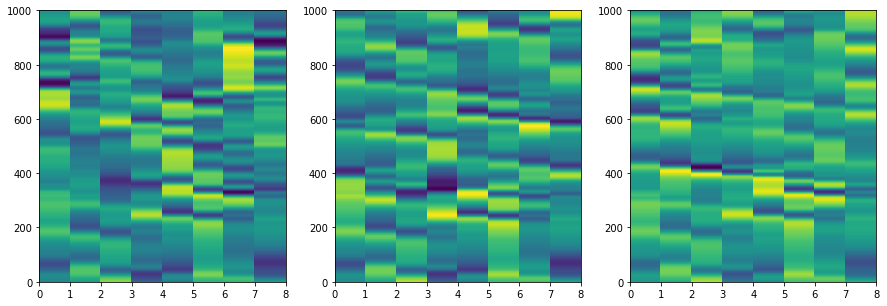

In [340]:
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1,3, i + 1)
    plt.pcolormesh(lorenz_forecasts[i].iloc[:, 2:])

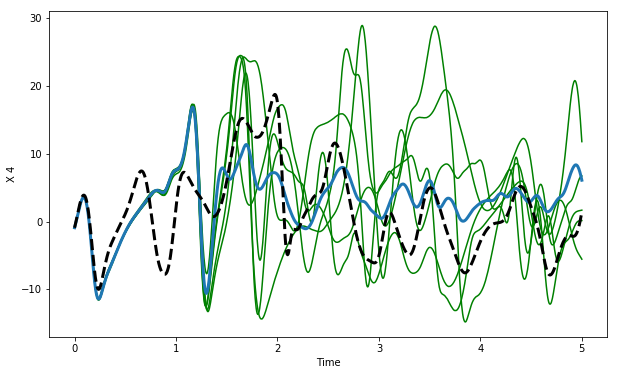

In [349]:
plt.figure(figsize=(10, 6))

for i in range(5):
    plt.plot(lorenz_forecasts[0]["time"], lorenz_forecasts[i]["X_4"], "g-")

plt.plot(lorenz_forecasts[0]["time"], np.mean([lorenz_forecasts[i]["X_4"] for i in range(10)], axis=0), lw=3)

plt.plot(lorenz_forecasts[0]["time"], x_vals[100000:100000 + 1001, 4], 'k--', lw=3)
plt.xlabel("Time")
plt.ylabel("X 4")

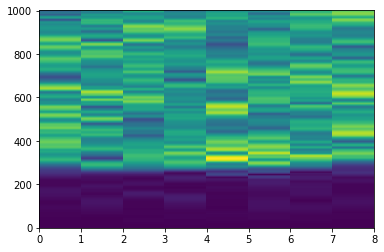

In [350]:
plt.subplots(1, 1, )
plt.pcolor(lorenz_forecast_cube.std(axis=0))

In [159]:
np.percentile(lorenz_forecast_cube[:, :, x_val], 90, axis=0).shape

(1001,)

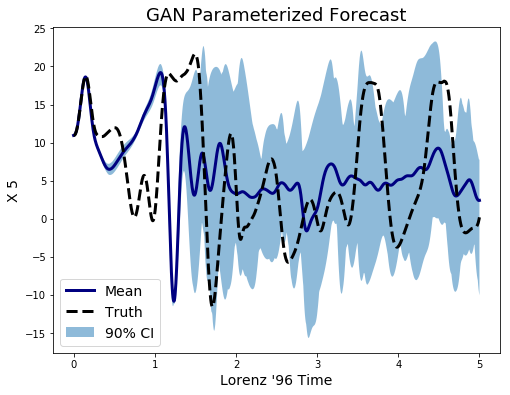

In [351]:
plt.figure(figsize=(8, 6))
x_val = 5
plt.fill_between(lorenz_forecasts[0]["time"],
                 np.percentile(lorenz_forecast_cube[:, :, x_val], 95, axis=0), 
                 np.percentile(lorenz_forecast_cube[:, :, x_val], 5, axis=0), alpha=0.5, label="90% CI")
plt.plot(lorenz_forecasts[0]["time"], lorenz_forecast_cube[:, :, x_val].mean(axis=0), color="navy", lw=3, label="Mean")
plt.plot(lorenz_forecasts[0]["time"], x_vals[100000:100000 + 1001, x_val], 'k--', lw=3, label="Truth")
plt.xlabel("Lorenz '96 Time", fontsize=14)
plt.ylabel("X 5", fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.title("GAN Parameterized Forecast", fontsize=18)
plt.savefig("../exp/lorenz_forecast_ts.png", dpi=200, bbox_inches="tight")